In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, LeakyReLU, BatchNormalization, multiply
from keras.layers import Conv2D, UpSampling2D, Reshape, Flatten, Dropout, ZeroPadding2D
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
IMAGE_CHANNELS = 1
BATCH_SIZE = 64
LATENT_DIMENSION = 100
IMAGE_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
NUM_CLASSES = 10
EPOCHS = 30000

In [3]:
def load_data():
    (x_train, y_train), (_, _) = mnist.load_data()
    x_train = x_train / 127.5 - 1.
    x_train = np.expand_dims(x_train, axis = 3)
    y_train = y_train.reshape(-1, 1)
    return x_train, y_train

In [4]:
x_train, y_train = load_data()
x_train.shape, y_train.shape

11493376/11490434 [==============================] - 1s 0us/step


((60000, 28, 28, 1), (60000, 1))

In [5]:
def build_generator():
    model = Sequential([
        Dense(128 * 7 * 7, input_dim = LATENT_DIMENSION, activation = 'relu'),
        Reshape((7, 7, 128)),
        BatchNormalization(momentum = 0.8),
        UpSampling2D(),
        Conv2D(128, kernel_size = 3, padding = "same", activation = 'relu'),
        BatchNormalization(momentum = 0.8),
        UpSampling2D(),
        Conv2D(64, kernel_size = 3, padding = "same", activation = 'relu'),
        BatchNormalization(momentum = 0.8),
        Conv2D(1, kernel_size = 3, padding = "same", activation = 'tanh'),
    ], name = 'Generator_Sequential')
    
    noise = Input(shape = (LATENT_DIMENSION, ))
    label = Input(shape = (1, ))
    label_embedding = Embedding(NUM_CLASSES, LATENT_DIMENSION)(label)
    label_embedding = Flatten()(label_embedding)
    model_input = multiply([noise, label_embedding])
    image = model(model_input)
    generator = Model([noise, label], image, name = 'Generator')
    return generator

In [6]:
def build_discriminator():
    model = Sequential([
        Conv2D(16, kernel_size = 3, strides = 2, input_shape = IMAGE_SHAPE, padding = "same"),
        LeakyReLU(alpha = 0.2),
        Dropout(0.25),
        Conv2D(32, kernel_size = 3, strides = 2, padding = "same"),
        ZeroPadding2D(padding = ((0, 1), (0, 1))),
        LeakyReLU(alpha = 0.2),
        Dropout(0.25),
        BatchNormalization(momentum = 0.8),
        Conv2D(64, kernel_size = 3, strides = 2, padding = "same"),
        ZeroPadding2D(padding = ((0, 1), (0, 1))),
        LeakyReLU(alpha = 0.2),
        Dropout(0.25),
        BatchNormalization(momentum = 0.8),
        Conv2D(128, kernel_size = 3, strides = 2, padding = "same"),
        LeakyReLU(alpha = 0.2),
        Dropout(0.25),
        Flatten()
    ], name = 'Discriminator_Sequential')
    
    image = Input(shape = IMAGE_SHAPE)
    features = model(image)
    validity = Dense(1, activation = 'sigmoid')(features)
    label = Dense(NUM_CLASSES, activation = 'softmax')(features)
    
    discriminator = Model(image, [validity, label], name = 'Discriminator')
    return discriminator

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
Discriminator_Sequential (Seque (None, 1152)         97536       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            1153        Discriminator_Sequential[1][0]   
__________________________________________________________________________________________________
dense_2 (Dense)      

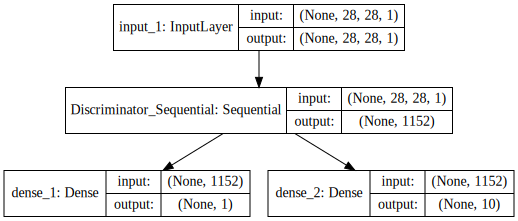

In [7]:
discriminator = build_discriminator()
discriminator.compile(
    loss = [
        'binary_crossentropy',
        'sparse_categorical_crossentropy'
    ],
    optimizer = Adam(0.0002, 0.5),
    metrics = ['accuracy']
)
discriminator.summary()
SVG(model_to_dot(discriminator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1000        input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
multiply_1

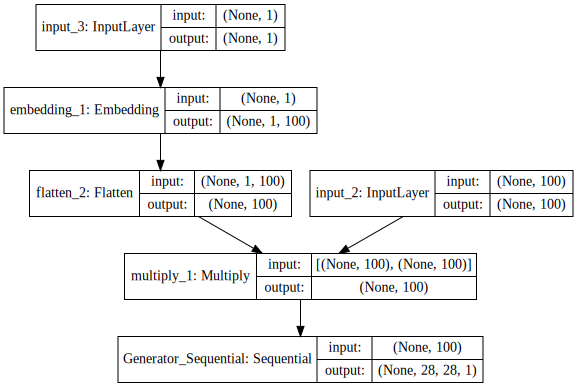

In [8]:
generator = build_generator()
generator.summary()
SVG(model_to_dot(generator, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GAN_Input_Noise (InputLayer)    (None, 100)          0                                            
__________________________________________________________________________________________________
GAN_Input_Label (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 28, 28, 1)    857705      GAN_Input_Noise[0][0]            
                                                                 GAN_Input_Label[0][0]            
__________________________________________________________________________________________________
Discriminator (Model)           [(None, 1), (None, 1 110219      Generator[1][0]                  
Total para

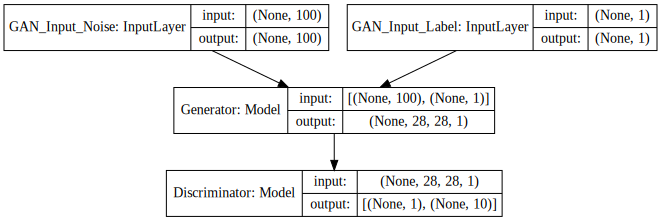

In [9]:
noise = Input(shape = (LATENT_DIMENSION, ), name = 'GAN_Input_Noise')
label = Input(shape = (1, ), name = 'GAN_Input_Label')
image = generator([noise, label])
discriminator.trainable = False
valid, target_label = discriminator(image)
gan = Model([noise, label], [valid, target_label])
gan.compile(
    loss = [
        'binary_crossentropy',
        'sparse_categorical_crossentropy'
    ],
    optimizer = Adam(0.0002, 0.5)
)
gan.summary()
SVG(model_to_dot(gan, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [10]:
def plot_images(generator, nrows = 2, ncols = 5, figsize = (16, 6)):
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.setp(axes.flat, xticks = [], yticks = [])
    noise = np.random.normal(0, 1, (nrows * ncols, LATENT_DIMENSION))
    labels = np.array(range(NUM_CLASSES)).reshape(-1, 1)
    generated_images = generator.predict([noise, labels])
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap = 'gray')
        ax.set_xlabel(str(labels[i]))
    plt.show()

Instructions for updating:
Use tf.cast instead.


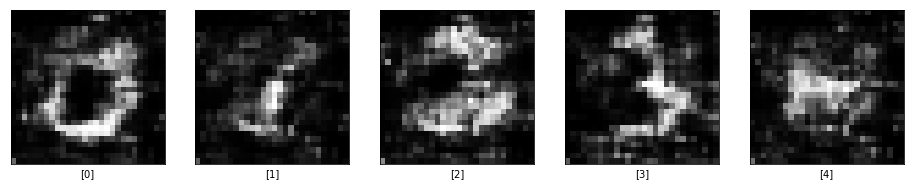

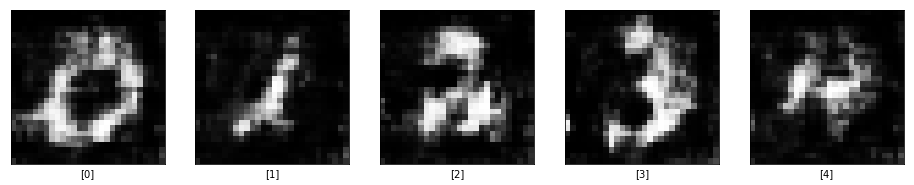

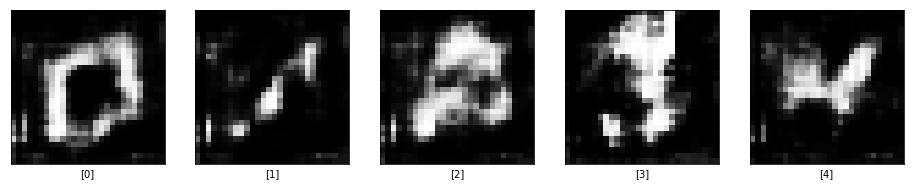

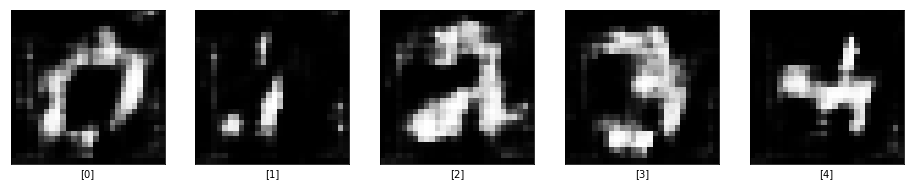

In [11]:
valid = -np.ones(shape = (BATCH_SIZE, 1))
fake = np.ones(shape = (BATCH_SIZE, 1))
generator_loss_history, discriminator_loss_history = [], []

for epoch in tqdm_notebook(range(1, EPOCHS + 1)):
    
    # Select a random batch
    index = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
    batch_images = x_train[index]
    batch_labels = y_train[index]
    
    # Adversarial Noise
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIMENSION))
    
    # Random Labels
    random_labels = np.random.randint(0, NUM_CLASSES, (BATCH_SIZE, 1))
    
    # Generating Fake Images
    generated_images = generator.predict([noise, random_labels])
    
    # Training the Disccriminator
    discriminator_loss_real = discriminator.train_on_batch(batch_images, [valid, batch_labels])
    discriminator_loss_fake = discriminator.train_on_batch(generated_images, [fake, random_labels])
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
    
    # Training the Generator
    generator_loss = gan.train_on_batch([noise, random_labels], [valid, random_labels])
    
    if epoch % 100 == 0:
        generator_loss_history.append(generator_loss)
        discriminator_loss_history.append(discriminator_loss)
    
    if epoch % 2000 == 0:
        plot_images(generator, nrows = 1, ncols = 5, figsize = (16, 4))

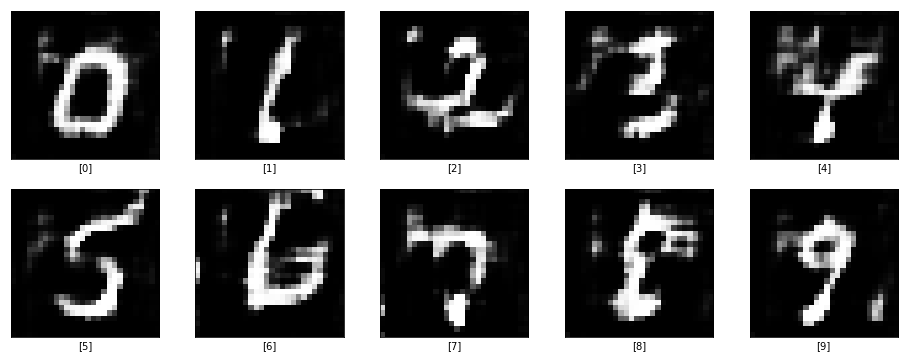

In [12]:
plot_images(generator)

In [13]:
generator.save('generator.h5')